<a href="https://colab.research.google.com/github/simulate111/mini-project-2-Abo/blob/main/MP2_sentiment-Marie-Helen%20Lindb%C3%A4ck.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning - Mini Project 2
## Sentiment Analysis

In [16]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [17]:
# Import the data
#uploaded = files.upload()

In [18]:
# Read the TSV file into a DataFrame
df = pd.read_csv("https://raw.githubusercontent.com/simulate111/mini-project-2-Abo/main/Sentiment140.tenPercent.sample.tweets.tsv", delimiter='\t')

In [19]:
df.head()

,sentiment_label,tweet_text
0,4,"@elephantbird Hey dear, Happy Friday to You A..."
1,4,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...


In [20]:
# change the positive label 4 to 1
df['sentiment_label'] = df['sentiment_label'].replace(4,1)

<Axes: xlabel='sentiment_label', ylabel='count'>

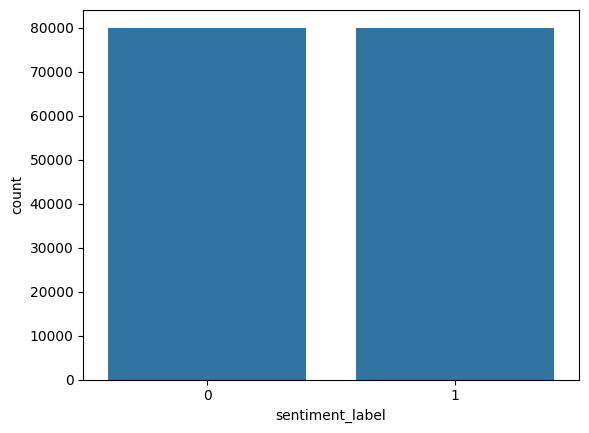

In [21]:
import seaborn as sns
# check if the dataset is balanced
sns.countplot(x='sentiment_label', data=df)

## Preprocess the data

In [22]:
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, Conv1D, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [23]:
# Download stopwords from NLTK
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# define a function for cleaning up the tweets
def preprocess_text(sen):
    # Remove usernames
    sentence = remove_username(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    # Convert to lowercase
    sentence = sentence.lower()

    # Lemmatization
    sentence = lemmatize_text(sentence)

    # Remove stopwords
    words = sentence.split()
    filtered_words = [word for word in words if word not in stop_words]
    sentence = ' '.join(filtered_words)

    return sentence

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [24]:
# define a function for removing usersnames from the tweets
def remove_username(text):
    pattern = r'@\w+'
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

In [25]:
# define a function for lemmatization
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')

# Initialize the WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    tokens = nltk.word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [26]:
# clean all the tweets and save them to a list X
X = []
sentences = list(df['tweet_text'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [27]:
# display the results of the prerocessing
X[:10]

['hey dear happy friday already rice bowl lunch',
 'ughhh layin downnnn waiting zeina cook breakfast',
 'reckon play even know nothing without',
 'know saw news',
 'sad http www fabchannel com ha closed one web service used year',
 'sings remember alwaysss hear radio never catch artist',
 'god ur side anything possible',
 'stupid',
 'delved back gut expression engine flexible cm use dev great client though',
 'awww take']

In [28]:
# compare to the original
for index in df['tweet_text'][:10]:
  print(index)

@elephantbird Hey dear, Happy Friday to You  Already had your rice's bowl for lunch ?
Ughhh layin downnnn    Waiting for zeina to cook breakfast
@greeniebach I reckon he'll play, even if he's not 100%...but i know nothing!! ;) It won't be the same without him. 
@vaLewee I know!  Saw it on the news!
very sad that http://www.fabchannel.com/ has closed down. One of the few web services that I've used for over 5 years 
@Fearnecotton who sings 'I Remember'? i alwaysss hear it on Radio 1 but never catch the artist 
With God on ur side anything is possible.... 
@LoveSmrs why being stupid? 
Having delved back into the guts of Expression Engine, its a flexible CMS if you have to use it as a dev, not great for clients though 
@emoskank awww   take him with you!


In [29]:
# save the sentiment labels to y
y = df['sentiment_label']

Pre-processing for the neural network

In [30]:
# devide the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [31]:
# initialize tokenizer with 5000 as the maximum number of words to keep (keep only the 5000 most frequent words)
tokenizer = Tokenizer(num_words=5000)
# fit the tokenizer to the training data
tokenizer.fit_on_texts(X_train)

# convert the text to sequences (each word in the text is replaced by its corresponing integer index created by the tokenizer)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [32]:
# calculate the vocabulary size
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

# set the maximum sequence lenght
maxlen = 40

# make all sequences the same lengt
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [33]:
# dowload pre-trained word vectors (the GloVe file glove.6B.100d.txt)
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2024-02-29 08:15:24--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-02-29 08:15:24--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.57MB/s    in 2m 43s  

2024-02-29 08:18:08 (5.04 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflatin

In [34]:
# Load pre-trained word embeddings from a GloVe file and create an embedding matrix
from numpy import array
from numpy import asarray
from numpy import zeros

# Initialize an empty dictionary
embeddings_dictionary = dict()
# Open the GloVe file
glove_file = open('glove.6B.100d.txt', encoding="utf8")

# Iterate through each line in the GloVe file
for line in glove_file:
    # split the line into a list of strings
    records = line.split()
    # extract the word
    word = records[0]
    # Convert the vector dimensions to a NumPy array with floats
    vector_dimensions = asarray(records[1:], dtype='float32')
    # Add the word and its corresponding vector representation to the dictionary
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [35]:
# Initialize an embedding matrix with zeros
embedding_matrix = zeros((vocab_size, 100))

# Iterate through each word in the vocabulary created by the tokenizer
# and assign an embedding vector to the corresponding row in the embedding matrix
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

## Recurrent Neural Network

In [36]:
# Creating a sequential model
model = Sequential()
# adding an embedding layer with the pretrained word embeddings
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
# Adding an LSTM layer with 128 units
model.add(LSTM(128))

# Adding a dense layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))
# Compiling the model with Adam optimizer and binary cross-entropy loss
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [37]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 100)           5796400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 5913777 (22.56 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 5796400 (22.11 MB)
_________________________________________________________________
None


In [38]:
# Train the model on the training data
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

# Evaluate the model on the test data
score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
800/800 [==============================] - 141s 173ms/step - loss: 0.5751 - acc: 0.6969 - val_loss: 0.5387 - val_acc: 0.7260
Epoch 2/6
800/800 [==============================] - 140s 175ms/step - loss: 0.5310 - acc: 0.7338 - val_loss: 0.5392 - val_acc: 0.7314
Epoch 3/6
800/800 [==============================] - 131s 164ms/step - loss: 0.5129 - acc: 0.7458 - val_loss: 0.5197 - val_acc: 0.7470
Epoch 4/6
800/800 [==============================] - 144s 180ms/step - loss: 0.4999 - acc: 0.7560 - val_loss: 0.5188 - val_acc: 0.7448
Epoch 5/6
800/800 [==============================] - 139s 174ms/step - loss: 0.4882 - acc: 0.7633 - val_loss: 0.5070 - val_acc: 0.7526
Epoch 6/6
1000/1000 [==============================] - 32s 32ms/step - loss: 0.5127 - acc: 0.7476


In [39]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5127364993095398
Test Accuracy: 0.7475625276565552


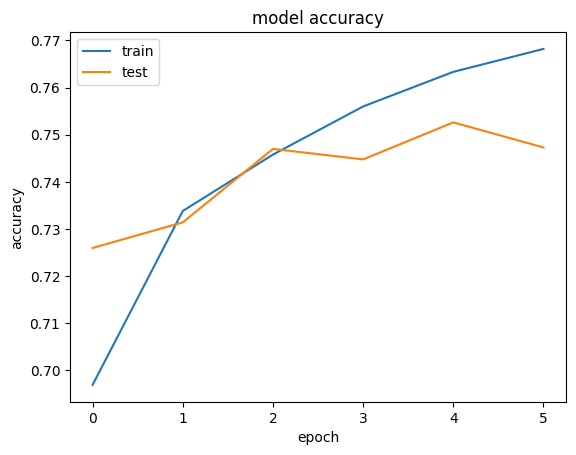

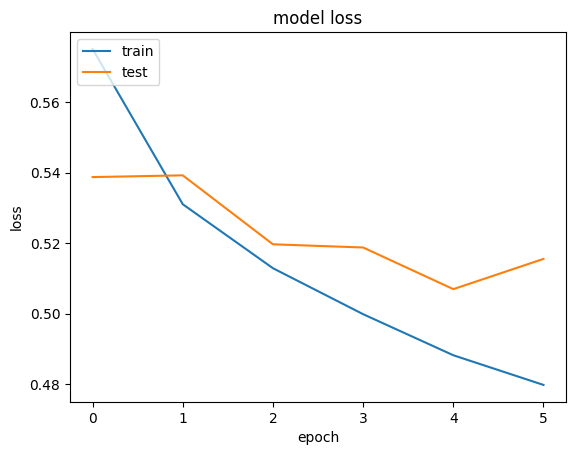

In [40]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Naive Beyes

In [41]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Feature Extraction
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(X).toarray()

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Training Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Prediction
y_pred = nb_classifier.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.75009375

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.74      0.75     16002
           1       0.75      0.76      0.75     15998

    accuracy                           0.75     32000
   macro avg       0.75      0.75      0.75     32000
weighted avg       0.75      0.75      0.75     32000

